In [2]:
import os
import time
import datetime
import json
import gc
from numba import jit
from scipy import stats

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

#import lightgbm as lgb
import xgboost as xgb
#from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

#import altair as alt
#from altair.vega import v5
#from IPython.display import HTML

# Read the file using pandas 

In [3]:
df_id = pd.read_csv("train_identity.csv")
df_trans = pd.read_csv("train_transaction.csv")

In [4]:
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
df_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Basic Statistic information on the data

In [6]:
def resumetable(df):
    
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [7]:
summary_df_id = resumetable(df_id)

Dataset Shape: (144233, 41)


In [8]:
summary_df_trans = resumetable(df_trans)

Dataset Shape: (590540, 394)


In [9]:
summary_df_id.head()

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,144233,2987004,2987008,2987010,17.14
1,id_01,int64,0,77,0,-5,-5,2.27
2,id_02,float64,3361,115655,70787,98945,191631,16.72
3,id_03,float64,77909,24,NaN,NaN,0,0.32
4,id_04,float64,77909,15,NaN,NaN,0,0.10


In [10]:
summary_df_trans.head()

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int64,0,2,0,0,0,0.22
2,TransactionDT,int64,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float64,0,20902,68.5,29,59,8.35
4,ProductCD,object,0,5,W,W,W,1.28


# Merge two data sets

In [11]:
train = pd.merge(df_trans, df_id, on='TransactionID', how='left')

In [12]:
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Checking if any value is less than or equal to '1' for both train and test

nunique() function return number of unique elements in the object. 
It returns a scalar value which is the count of all the unique values in the Index. 
By default the NaN values are not included in the count. 
If dropna parameter is set to be False then it includes NaN value in the count.

In [13]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [13]:
train.shape

(590540, 434)

# train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation

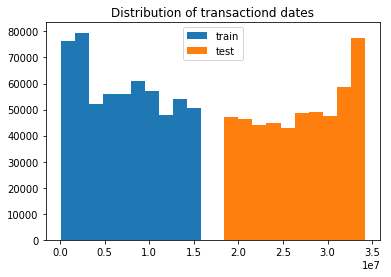

In [19]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

# Preparing Data for modeling

In [20]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [21]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [22]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

82

In [23]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [24]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']


for col in cat_cols:
    
    if col in train.columns:
        
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))  

In [25]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,4248,501,50,1,42,...,136,6,461,4,2,2,2,2,2,2740
1,2987001,0,86401,29.0,4,9979,304,50,2,2,...,136,6,461,4,2,2,2,2,2,2740
2,2987002,0,86469,59.0,4,11850,390,50,4,66,...,136,6,461,4,2,2,2,2,2,2740
3,2987003,0,86499,50.0,4,8796,467,50,2,17,...,136,6,461,4,2,2,2,2,2,2740
4,2987004,0,86506,50.0,1,11687,414,50,2,2,...,162,3,268,3,1,0,1,1,1,1565


In [26]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

X = clean_inf_nan(X)

In [27]:
gc.collect()

4409

# Here we are using timeseriesplit to split our training dataset into training and validation set

'n-splits' determine the number folds. N-1 in this case we split our

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)

In [29]:
for train_index, test_index in folds.split(X):
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Creating classification model

In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

In [34]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\am301666\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\am301666\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [35]:
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [36]:
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.30%


In [37]:
y_pred_test = model.predict(test)

In [38]:
test['predicted'] = y_pred_test

In [42]:
test.predicted.unique()

array([0, 1], dtype=int64)